# BNN on Pynq

This notebook covers how to use Binary Neural Networks on Pynq. 
It shows an example of handwritten digit recognition using a binarized neural network composed of 4 fully connected layers with 1024 neurons each, trained on the MNIST dataset of handwritten digits. 
In order to reproduce this notebook, you will need an external USB Camera connected to the PYNQ Board.

## 1.Instantiate the classifier
Creating a classifier will automatically download the correct bitstream onto the device and load the weights trained on the specified dataset. By default there is one set of weights for the LFC network, the MNIST

In [1]:
import bnn
print(bnn.available_params(bnn.NETWORK_LFC))

classifier = bnn.PynqBNN(network=bnn.NETWORK_LFC)

['mnist']


# 2. Download the network parameters
The parameters of the network are downloaded in the Programmable logic memory, storing the trained weights on the MNIST dataset. 

In [2]:
classifier.load_parameters("mnist")

## 3. Load the image from the camera
The image is captured from the external USB camera and stored locally. The image is then enhanced in contract and brightness to remove background noise. 
The resulting image should show the digit on a white background:

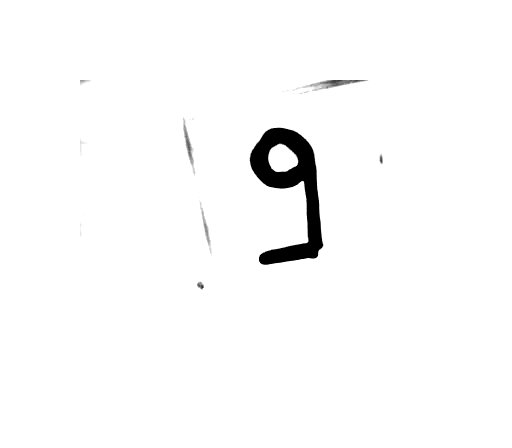

In [3]:
from PIL import Image as PIL_Image
from PIL import ImageEnhance
from PIL import ImageOps

orig_img_path = '/home/xilinx/bnn/image.jpg'
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2> /dev/null # Loading the image from the webcam

img = PIL_Image.open(orig_img_path).convert("L")                          # convert in black and white
#Image enhancement                
contr = ImageEnhance.Contrast(img)
img = contr.enhance(3)                                                    # The enhancement values (contrast and brightness) 
bright = ImageEnhance.Brightness(img)                                     # depends on backgroud, external lights etc
img = bright.enhance(4.0)          

img = img.rotate(180)                                                     # Rotate the image (depending on camera orientation)
#Adding a border for future cropping
img = ImageOps.expand(img,border=80,fill='white') 
img

## 4. Evaluate digit location in the image
The center of mass of the image is evaluated to properly crop the image and extract the written digit only. 

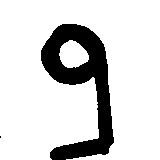

In [4]:
from PIL import Image as PIL_Image
import numpy as np
import math
threshold = 180  
img = img.point(lambda p: p > threshold and 255)  
immat = img.load()
(X, Y) = img.size
m = np.zeros((X, Y))
# Spanning the image to evaluate center of mass
for x in range(X):
    for y in range(Y):
        m[x, y] = immat[(x, y)] <= 250
m = m / np.sum(np.sum(m))
dx = np.sum(m, 1)
dy = np.sum(m, 0)

# Evalate center of mass
cx = math.ceil(np.sum(dx * np.arange(X)))
cy = math.ceil(np.sum(dy * np.arange(Y)))
img = img.crop((cx-80,cy-80,cx+80,cy+80))

img

## 5. Convert to BNN input format
The image is resized to comply with the MNIST standard. The image is resized at 28x28 pixels and the colors inverted. 

In [5]:
from array import *
from PIL import Image as PIL_Image
#Resize the image and invert it (white on black)
smallimg = img.resize((28, 28))
smallimg = ImageOps.invert(smallimg)


data_image = array('B')

pixel = smallimg.load()
for x in range(0,28):
	for y in range(0,28):
		data_image.append(pixel[y,x])      
        
# Setting up the header of the MNIST format file        
hexval = "{0:#0{1}x}".format(1,6)
header = array('B')
header.extend([0,0,8,1,0,0])
header.append(int('0x'+hexval[2:][:2],16))
header.append(int('0x'+hexval[2:][2:],16))
header.extend([0,0,0,28,0,0,0,28])
header[3] = 3 # Changing MSB for image data (0x00000803)

data_image = header + data_image
output_file = open('/home/xilinx/bnn/data/image.images-idx3-ubyte', 'wb')
data_image.tofile(output_file)
output_file.close()
smallimg

# 6. Launching BNN in hardware
The image is passed in the PL and the inference is performed

In [6]:
classifier.inference("/home/xilinx/bnn/data/image.images-idx3-ubyte")

Inference took 116.00 microseconds
Classification rate: 8620.69 images per second


9

# 7. Launching BNN in software
The inference on the same image is performed in sofware on the ARM core

In [7]:
classifier_sw3 = bnn.PynqBNN(network=bnn.NETWORK_LFC,runtime=bnn.RUNTIME_SW)
classifier_sw3.load_parameters("mnist")
classifier_sw3.inference("/home/xilinx/bnn/data/image.images-idx3-ubyte")

Inference took 53307.00 microseconds
Classification rate: 18.76 images per second


9

# 8. Launching classification in HW with different network
The image is passed in the PL and the inference is performed using the CNV network trained on the Street View house number dataset

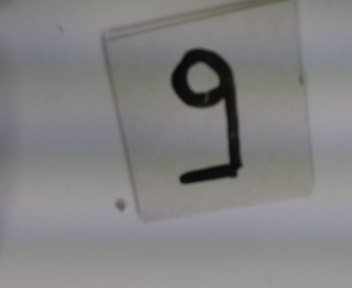

Inference took 2242.00 microseconds
Classification rate: 446.03 images per second
Class name: 9


In [8]:
from IPython.display import display
img = PIL_Image.open(orig_img_path).rotate(180)
display(img)
classifier_cnv = bnn.CnvClassifier('streetview')
class_out=classifier_cnv.classify_image(img)
print("Class name: {0}".format(classifier_cnv.class_name(class_out)))